# SeSiMe
### Sentence/Sequence Similarity Measure

### Goal:  Compare/benchmark different similarity measures for MS-MS spectra
Import MS data and create documents.

Testing here: Model trained on very large MS/MS spectral dataset ("all of gnps").
### here: GNPS Dataset of about 500,000 spectra.

In [1]:
# data locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_DATA = ROOT + "\\SeSiMe\\data\\"
PATH_SAVE_MODEL = ROOT + "\\SeSiMe\\models_trained\\"
PATH_SESIME = ROOT + "\\SeSiMe\\"

PATH_NPLINKER = ROOT + "\\nplinker\\prototype\\"
mgf_file = PATH_MS_DATA + "specs_ms.mgf"

In [2]:
# import general packages
import sys
sys.path.insert(0, PATH_NPLINKER)
sys.path.insert(0, PATH_SESIME)

import helper_functions as functions
import MS_functions

import numpy as np
from metabolomics import load_spectra

In [3]:
# Import / Load data from gnps/unique smiles dataset
results_file = "filtered_data_unique_smiles_minpeak10_loss500_2dec.json"

spectra, spectra_dict, MS_documents, MS_documents_intensity, sub_spectra_metadata = MS_functions.load_MGF_data(PATH_SAVE_DATA,
                  mgf_file, 
                 results_file = results_file,
                 num_decimals = 2,
                 min_frag = 0.0, max_frag = 1000.0,
                 min_loss = 5.0, max_loss = 500.0,
                 min_intensity_perc = 0,
                 exp_intensity_filter = 0.01,
                 min_peaks = 10,
                 peaks_per_mz = 15/200,
                 peak_loss_words = ['peak_', 'loss_'], #['mz_', 'mz_'], 
                 sub_spectra = False)

Spectra json file found and loaded.


#### Switch to general SeSiMe functionality
Once we have a corpus (e.g. through cells above), we can use SeSiMe to apply different similarity measuring methds. 

In [4]:
from Similarities import SimilarityMeasures

MS_measure = SimilarityMeasures(MS_documents)

Using TensorFlow backend.


In [5]:
MS_measure.preprocess_documents(0.2, min_frequency = 2, create_stopwords = False)
print("Number of unique words: ", len(MS_measure.dictionary))

Preprocess documents...
Number of unique words:  67429


### Note
In total it would be about 100.000 peak-words plus about 50.000 loss-words. Many occur only once in the entire corpus and are hence filtered out (makes not sense to place them somewhere in word-space, would be arbitrary!).

Few also are filtered out because they occur too often (in more than 20% of the spectra). Those words have little discriminative power and are hence ignored. Might still be worth keeping them in for comparison!

## Word2Vec -based approach
### Use pre-trained word2vec model. 

+ Model was trained on all-GNPS dataset (about 500,000 spectra, 427100 of which were kept and used for training)

In [27]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [28]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = None, #'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
529  out of  67429  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  105  of  100 .Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents.830  of  9550  documents.2460  of  9550  documents.  of  9550  documents. Calculated centroid vectors for  7360  of  9550  documents. 9550  documents.

In [25]:
len(MS_measure.model_word2vec.wv.vocab)

144285

This has calculated (cosine) distances between all spectra in an all-vs-all fashion.
The "num_hits" closest candidates for each spectrum are listed in two matrices.

One stores the distances, the other the respective IDs.

## Benchmark similarity measure

### Calculate molecular fingerprints
Here using: morgen-3 (alternative would be "daylight")  
Method will have problems with some smiles, those will be excluded from further analysis.

In [12]:
from MS_functions import get_mol_fingerprints
molecules, fingerprints_m3, exclude_IDs = get_mol_fingerprints(spectra_dict, method = "morgan3")
exclude = [np.where(np.array(sub_spectra_metadata)[:,1] == x)[0][0] for x in exclude_IDs]

Problem with molecule 7402
Could not be solved by using the InChikey.
Problem with molecule 7452
Could not be solved by using the InChikey.
Problem with molecule 7522
Could not be solved by using the InChikey.
Problem with molecule 7612
Could not be solved by using the InChikey.
Problem with molecule 13527
Could not be solved by using the InChikey.
Problem with molecule 13771
Could not be solved by using the InChikey.
Problem with molecule 14111
Could not be solved by using the InChikey.
Problem with molecule 14429
Could not be solved by using the InChikey.
Problem with molecule 14652
Could not be solved by using the InChikey.
Problem with molecule 15085
Could not be solved by using the InChikey.
Problem with molecule 15140
Could not be solved by using the InChikey.
Problem with molecule 15175
Could not be solved by using the InChikey.
Problem with molecule 15531
Could not be solved by using the InChikey.
Problem with molecule 15810
Could not be solved by using the InChikey.
Problem wi

### Get molecular similarity matrix (based on molecular fingerprints).  
Still named TANIMOTO, but that is only for daylight fingerprints. For morgan-3 fingerprints it's currently actually using a dice score.

In [13]:
filename = PATH_SAVE_DATA + "tanimoto_gnps_uniquesmiles_exp001_loss500_minpeak10_dec2_morgan3.npy"
tanimoto_similarities = MS_functions.tanimoto_matrix(spectra, 
                                                      fingerprints_m3,
                                                      filename = filename)

Tanimoto similarity scores found and loaded.


### Calculate all-vs-all similarity matrix

In [29]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [9]:
from matplotlib import pyplot as plt
import matplotlib

In [30]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

In [17]:
def binned_scatter_plot(bins_x, bins_y, H, edges):
    data_x = []
    data_y = []
    data_z = []
    data_z_norm = []
    data_y_mean = []
    for i in range(bins_x):
        for j in range(bins_y):
            data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
            data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
            mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
            data_y_mean.append(mean_mol_score)
            data_z_norm.append(np.sum(H[i,j])/np.sum(H[i,:]))
            data_z.append(np.sum(H[i,:]))

    fig, ax = plt.subplots(figsize=(15,10))
    cm = plt.cm.get_cmap('copper_r')  #plt.cm.get_cmap('RdYlBu')

    ax.scatter(data_x, data_y, s=1000*np.array(data_z_norm), cmap=cm, alpha=0.6)
    plt.plot(data_x, data_y_mean, color='black')
    plt.xlabel("g(s,s') (centroid/Word2Vec)")
    plt.ylabel("molecular similarity (f(t,t'))")
    plt.title("Word2Vec vs. molecular similarity")

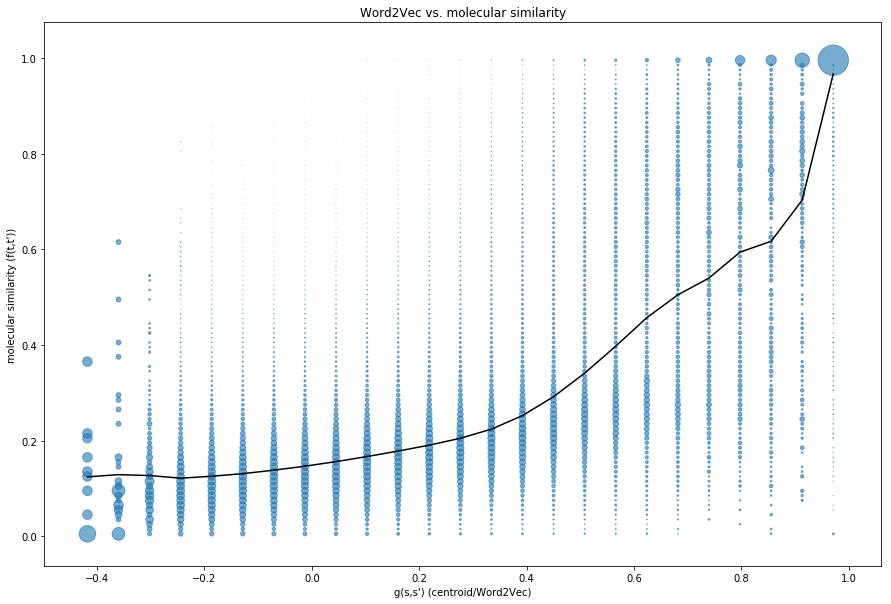

In [15]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.6568745293306828


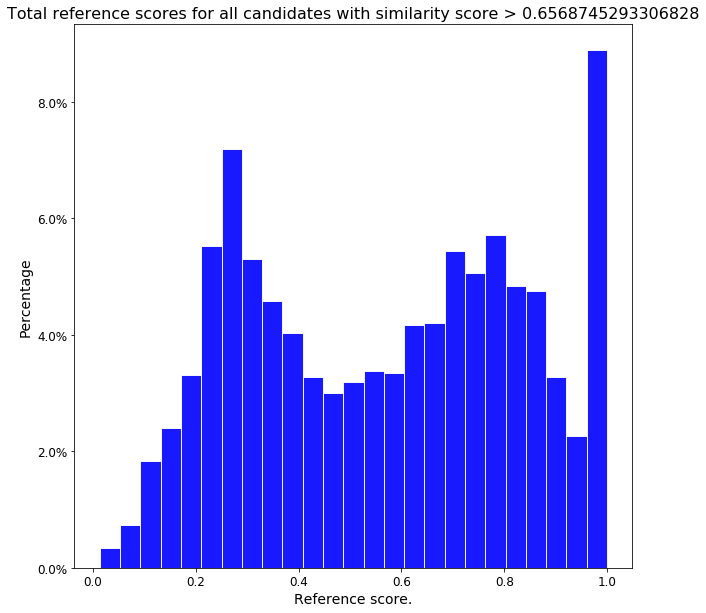

Percentage of highly similar molecules within selection:  58.48 %


In [31]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

In [16]:
def averaged_scatter_plot(bins_x, H, edges):
    data_x = []
    data_y = []
    data_z = []
    for i in range(bins_x):
        data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
    #        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
        mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
        data_y.append(mean_mol_score)
        data_z.append(np.sum(H[i,:]))
        
    fig, ax = plt.subplots(figsize=(10,10))
    cm = plt.cm.get_cmap('RdYlBu')

    plt.scatter(data_x, data_y, s = np.array(data_z)**0.5, c = data_y, cmap=cm, alpha = 0.5)
    plt.plot(data_x, data_y, color='black')
    plt.xlabel("Spectral similarity score (centroid/Word2Vec)")
    plt.ylabel("Molecular similarity score (Dice score, morgan3 fingerprints)")
    plt.title("Performance centroid/Word2Vec score" )

    # Optionally add a colorbar
    max_color = np.max(data_y)
    min_color = np.min(data_y)
    color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
    cax, _ = matplotlib.colorbar.make_axes(ax)
    cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
    cbar.ax.set_yticklabels([x for x in list(color_ticks)])
    plt.ylabel("molecular similarity (f(t,t'))")

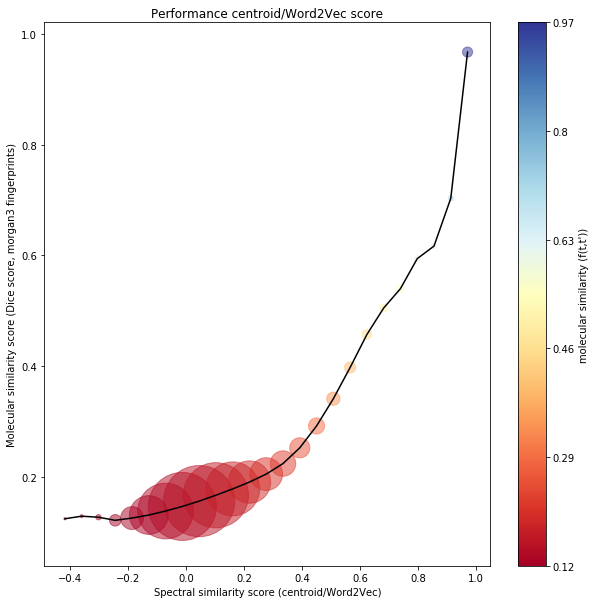

In [18]:
averaged_scatter_plot(bins_x, H, edges)

### Option 2: word vectors weighted by tfidf * sqrt(norm(intensity))

In [32]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'update', #'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
529  out of  67429  'words' were not found in the word2vec model.
The word2vec model will hence be updated by additional training.
 Epoch  110  of  100 .Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents. of  9550  documents. of  9550  documents.5970  of  9550  documents. 9550  documents.

In [33]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [34]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

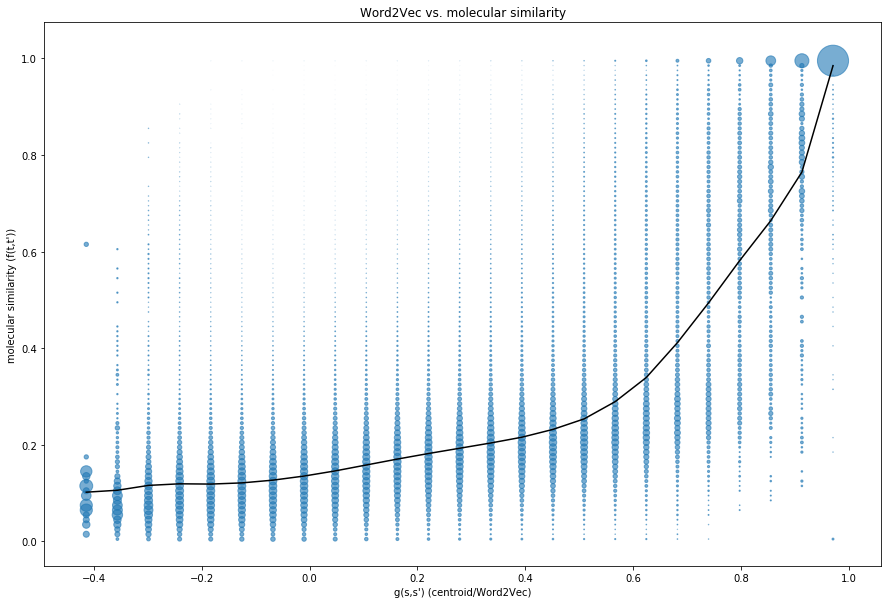

In [22]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.7383614564144401


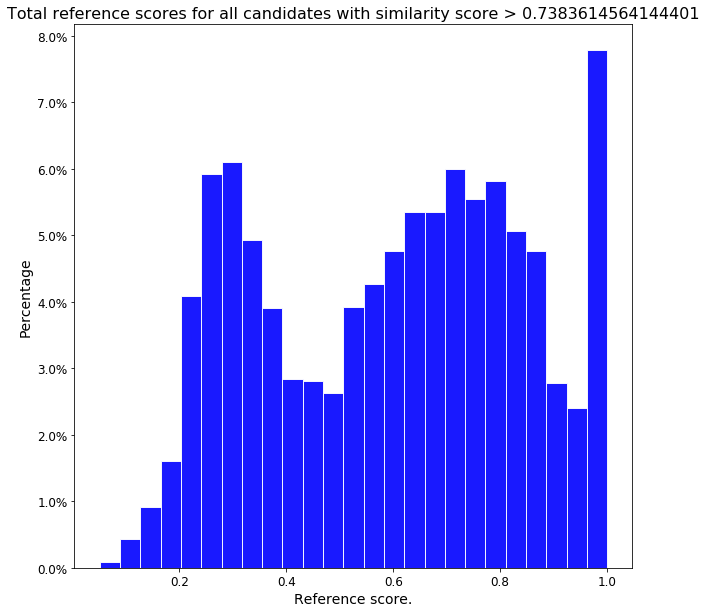

Percentage of highly similar molecules within selection:  63.77 %


In [23]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

In [35]:
bins_x = 50
bins_y = 25

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

In [36]:
data_x = []
data_y = []
data_z = []
data_y_mean = []
for i in range(bins_x):
    for j in range(bins_y):
        data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
        mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
        data_y_mean.append(mean_mol_score)
        data_z.append(np.sum(H[i,j]))#/np.sum(H[i,:]))

Text(0, 0.5, "molecular similarity (f(t,t'))")

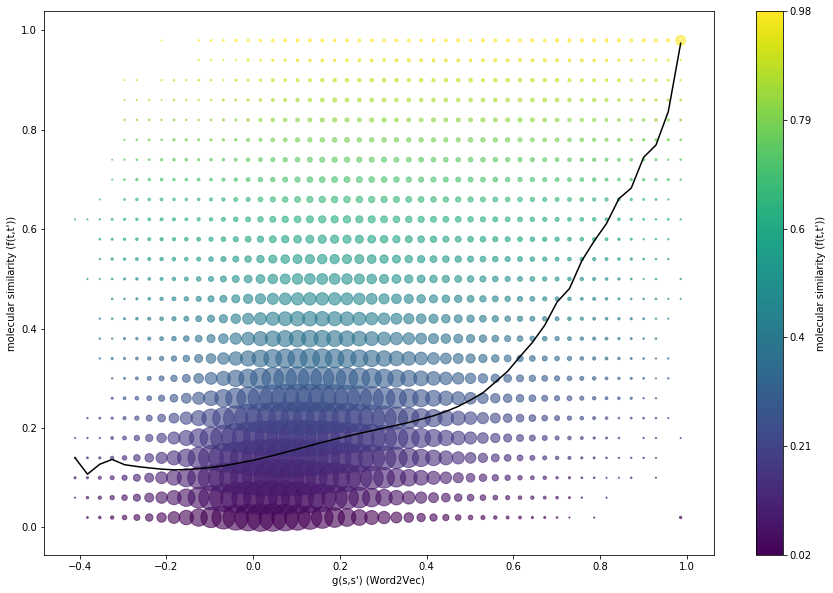

In [37]:
fig, ax = plt.subplots(figsize=(15,10))
cm = plt.cm.get_cmap('viridis')
#100*np.array(data_z)**0.5 c=data_y, 
ax.scatter(data_x, data_y, s=1*np.array(data_z)**0.5, c=data_y, cmap=cm, alpha=0.6)
plt.plot(data_x, data_y_mean, color='black')
plt.xlabel("g(s,s') (Word2Vec)")
plt.ylabel("molecular similarity (f(t,t'))")

# Optionally add a colorbar
max_color = np.max(data_y)
min_color = np.min(data_y)
color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels([x for x in list(color_ticks)])
plt.ylabel("molecular similarity (f(t,t'))")

### Option 3: Ignore missing words + word vectors weighted by tfidf * norm(intensity)

In [6]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [7]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = None, #'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
529  out of  67429  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents. of  9550  documents.

In [10]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [14]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

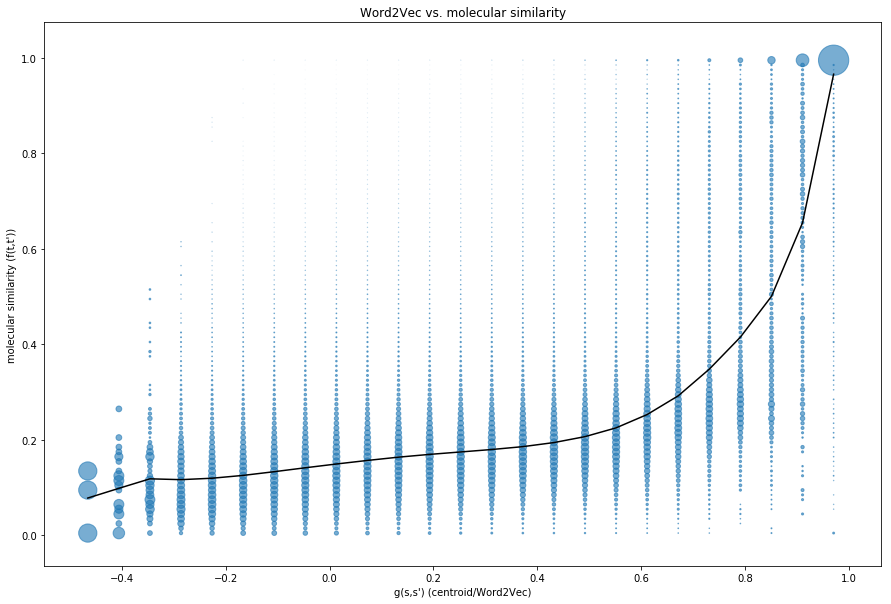

In [18]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.7473745805961228


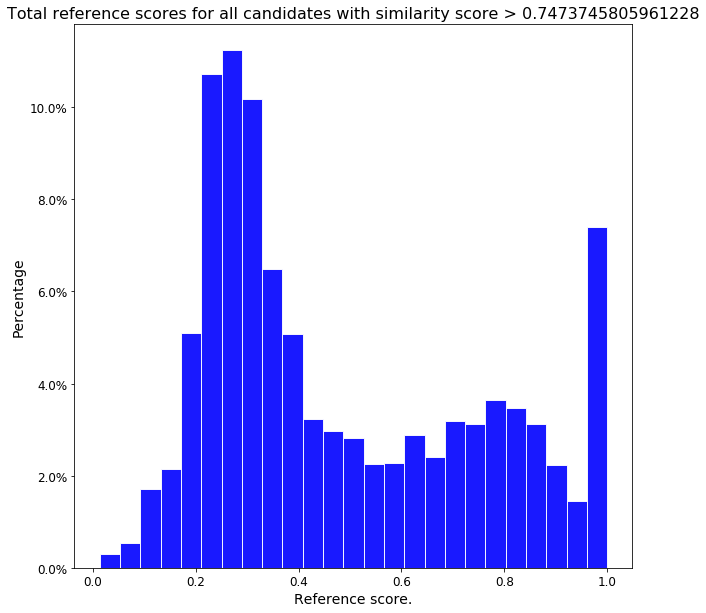

Percentage of highly similar molecules within selection:  40.29 %


In [19]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Option 3: Ignore missing words + word vectors weighted by tfidf * norm(intensity)

In [6]:
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


In [7]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = None, #'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
529  out of  67429  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
No tfidf model found.
  Calculated centroid vectors for  9550  of  9550  documents. of  9550  documents.

In [10]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [14]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

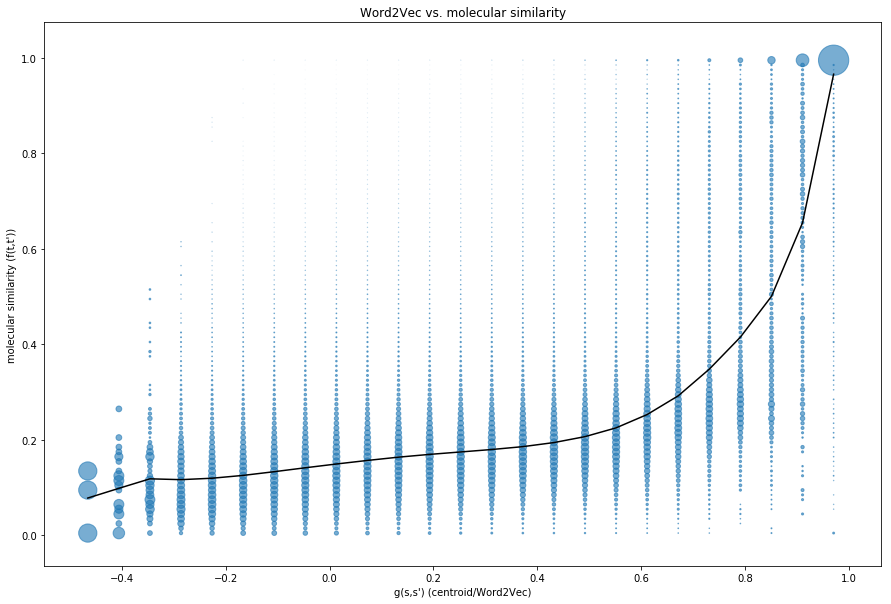

In [18]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.7473745805961228


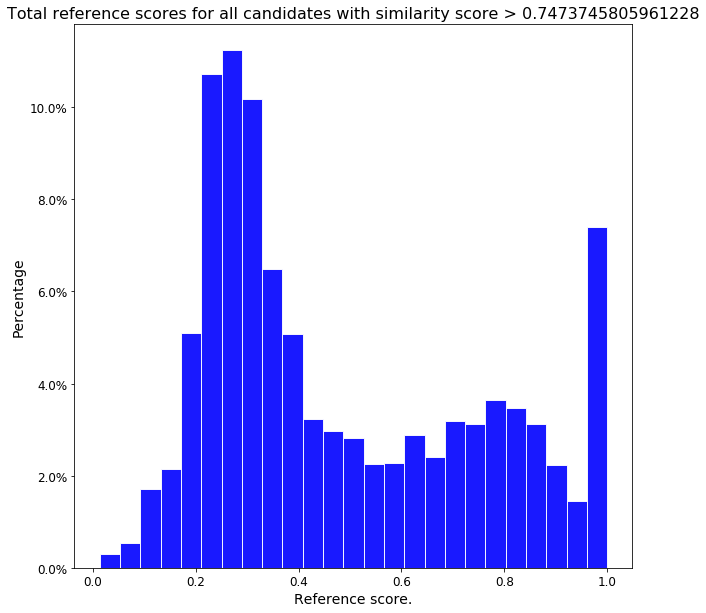

Percentage of highly similar molecules within selection:  40.29 %


In [19]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

### Option 4: Ignore missing words + word vectors weighted by tfidf * sqrt(norm(intensity))

In [20]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(method = 'ignore',
                             extra_weights = MS_documents_intensity, 
                             tfidf_weighted = True, 
                             weight_method = 'sqrt', 
                             tfidf_model = None,
                             extra_epochs = 5)

Not all 'words' of the given documents are present in the trained word2vec model!
529  out of  67429  'words' were not found in the word2vec model.
'Words'missing in the pretrained word2vec model will be ignored.
Removing missing 'words' from corpus...
Using present tfidf model.
  Calculated centroid vectors for  9550  of  9550  documents. of  9550  documents. of  9550  documents.8980  of  9550  documents.

In [21]:
from scipy import spatial
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

### Plot data

In [22]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

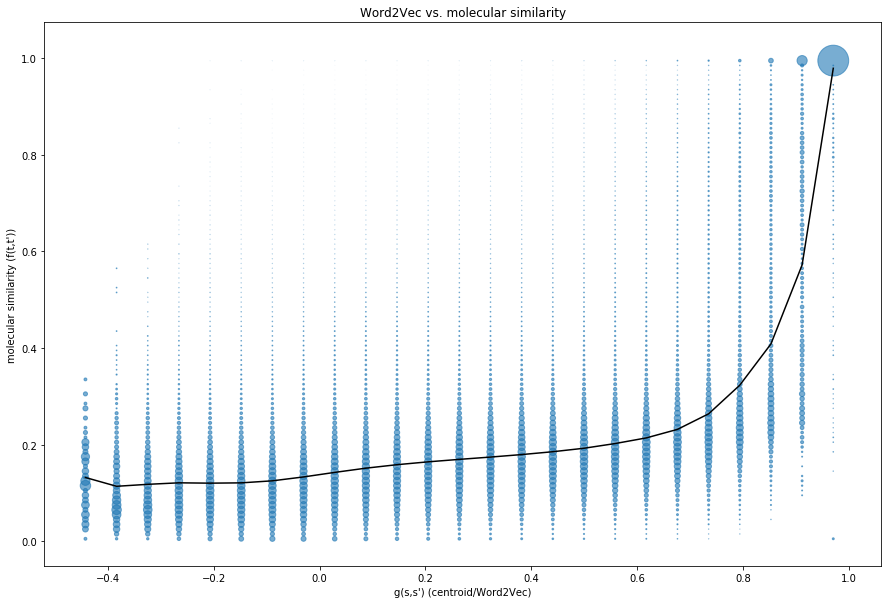

In [23]:
binned_scatter_plot(bins_x, bins_y, H, edges)

Set similarity threshold to:  0.8254387168904159


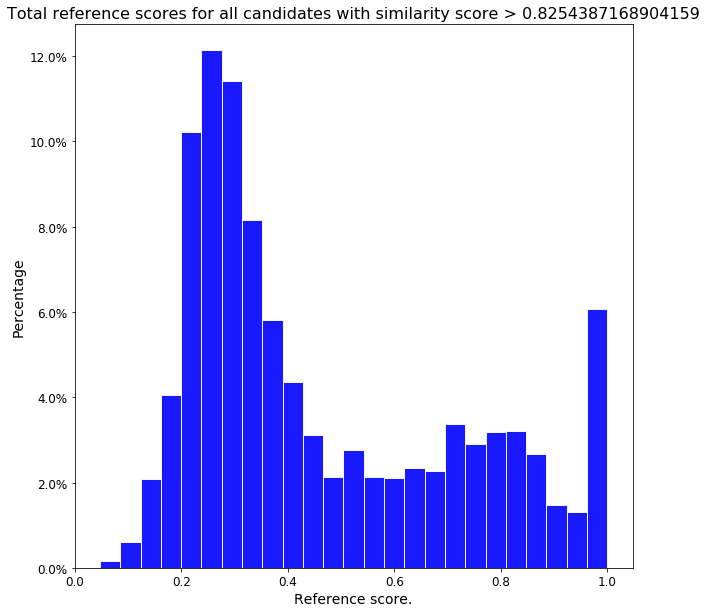

Percentage of highly similar molecules within selection:  35.74 %


In [24]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")
 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

## Compare to Word2Vec model trained on the dataset itself!

In [19]:
#file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_allgnps_d300_w300_iter100_loss500_minpeak10_dec2.model'
file_model_word2vec = PATH_SAVE_MODEL + 'model_w2v_MS_gnps_uniquesmiles_d300_w300_iter100_loss500_minpeak10_dec2.model'
MS_measure.build_model_word2vec(file_model_word2vec, size=300, window=300, 
                             min_count=1, workers=4, iter=100, 
                             use_stored_model=True)

Load stored word2vec model ...


### Option 1: word vectors weighted by tfidf + normalised intensity

In [20]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(extra_weights = MS_documents_intensity, 
                                tfidf_weighted=True, 
                                weight_method = None,
                                extra_epochs=5)
#MS_measure.get_centroid_similarity(num_hits=25, method='cosine')

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  9550  of  9550  documents. of  9550  documents. 2460  of  9550  documents.5050  of  9550  documents. of  9550  documents. 9550  documents.

In [21]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [22]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

In [23]:
data_x = []
data_y = []
data_z = []
data_z_norm = []
data_y_mean = []
for i in range(bins_x):
    for j in range(bins_y):
        data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
        mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
        data_y_mean.append(mean_mol_score)
        data_z_norm.append(np.sum(H[i,j])/np.sum(H[i,:]))
        data_z.append(np.sum(H[i,:]))

Text(0.5, 1.0, 'Word2Vec vs. molecular similarity')

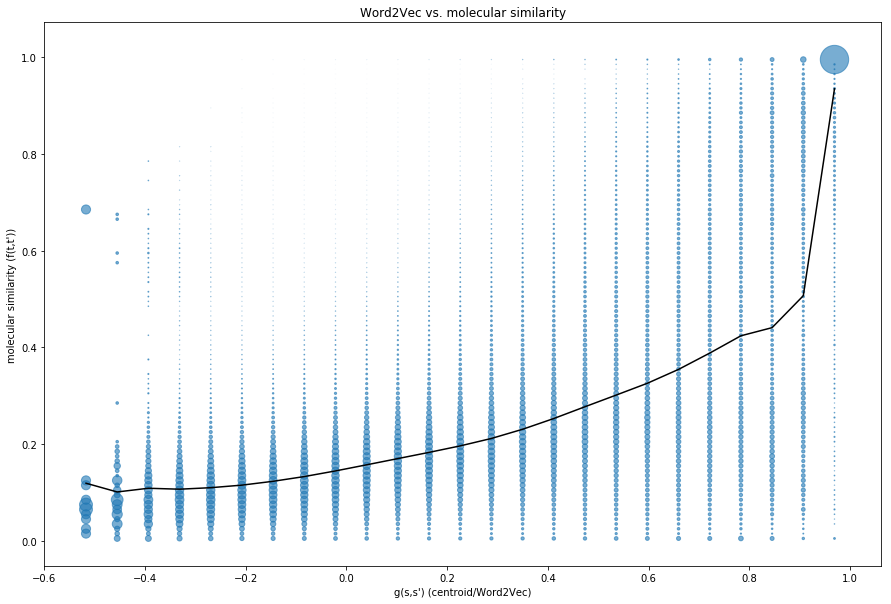

In [24]:
fig, ax = plt.subplots(figsize=(15,10))
cm = plt.cm.get_cmap('copper_r')  #plt.cm.get_cmap('RdYlBu')

ax.scatter(data_x, data_y, s=1000*np.array(data_z_norm), cmap=cm, alpha=0.6)
plt.plot(data_x, data_y_mean, color='black')
plt.xlabel("g(s,s') (centroid/Word2Vec)")
plt.ylabel("molecular similarity (f(t,t'))")
plt.title("Word2Vec vs. molecular similarity")

Set similarity threshold to:  0.8699657331111491


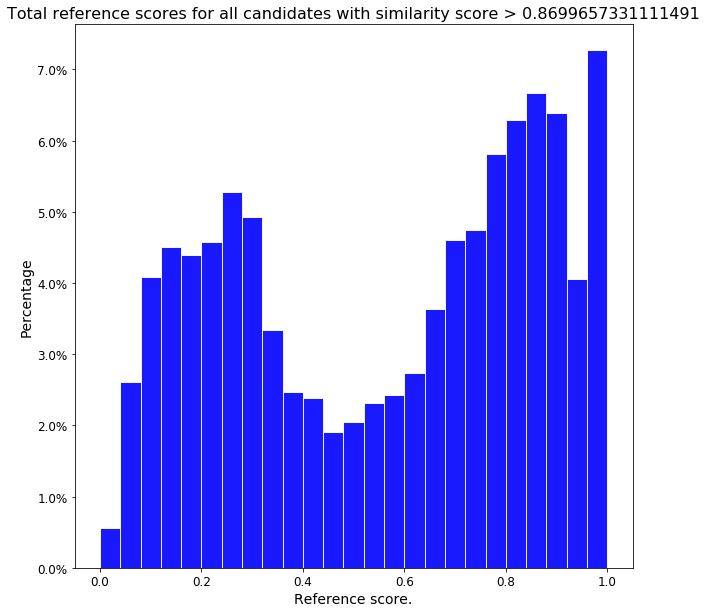

Percentage of highly similar molecules within selection:  58.97 %


In [25]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

In [26]:
data_x = []
data_y = []
data_z = []
for i in range(bins_x):
    data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
#        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
    mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
    data_y.append(mean_mol_score)
    data_z.append(np.sum(H[i,:]))

Text(0, 0.5, "molecular similarity (f(t,t'))")

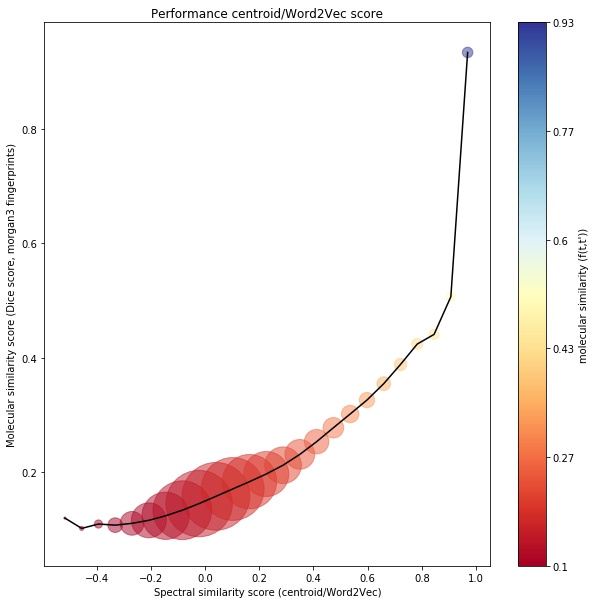

In [27]:
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')

plt.scatter(data_x, data_y, s = np.array(data_z)**0.5, c = data_y, cmap=cm, alpha = 0.5)
plt.plot(data_x, data_y, color='black')
plt.xlabel("Spectral similarity score (centroid/Word2Vec)")
plt.ylabel("Molecular similarity score (Dice score, morgan3 fingerprints)")
plt.title("Performance centroid/Word2Vec score" )

# Optionally add a colorbar
max_color = np.max(data_y)
min_color = np.min(data_y)
color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels([x for x in list(color_ticks)])
plt.ylabel("molecular similarity (f(t,t'))")

### Option 2: word vectors weighted by tfidf + sqrt(normalised intensity)

In [28]:
# Use peak intensities as extra weights
MS_measure.get_vectors_centroid(extra_weights = MS_documents_intensity, 
                                tfidf_weighted=True, 
                                weight_method = 'sqrt',
                                extra_epochs=5)
#MS_measure.get_centroid_similarity(num_hits=25, method='cosine')

All 'words' of the given documents were found in the trained word2vec model.
  Calculated centroid vectors for  9550  of  9550  documents. 9550  documents. documents. documents. of  9550  documents. documents. documents. Calculated centroid vectors for  8140  of  9550  documents.

In [29]:
# Calculate matrix of all-vs-all centroid similarity scores:
M_sim_ctr = 1 - spatial.distance.cdist(MS_measure.vectors_centroid, MS_measure.vectors_centroid, 'cosine')

In [30]:
bins_x = 25
bins_y = 100

H, edges = np.histogramdd([M_sim_ctr.reshape(9550**2), 
                           tanimoto_similarities.reshape(9550**2)], 
                          bins = (bins_x, bins_y))

In [31]:
data_x = []
data_y = []
data_z = []
data_z_norm = []
data_y_mean = []
for i in range(bins_x):
    for j in range(bins_y):
        data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
        mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
        data_y_mean.append(mean_mol_score)
        data_z_norm.append(np.sum(H[i,j])/np.sum(H[i,:]))
        data_z.append(np.sum(H[i,:]))

Text(0.5, 1.0, 'Word2Vec vs. molecular similarity')

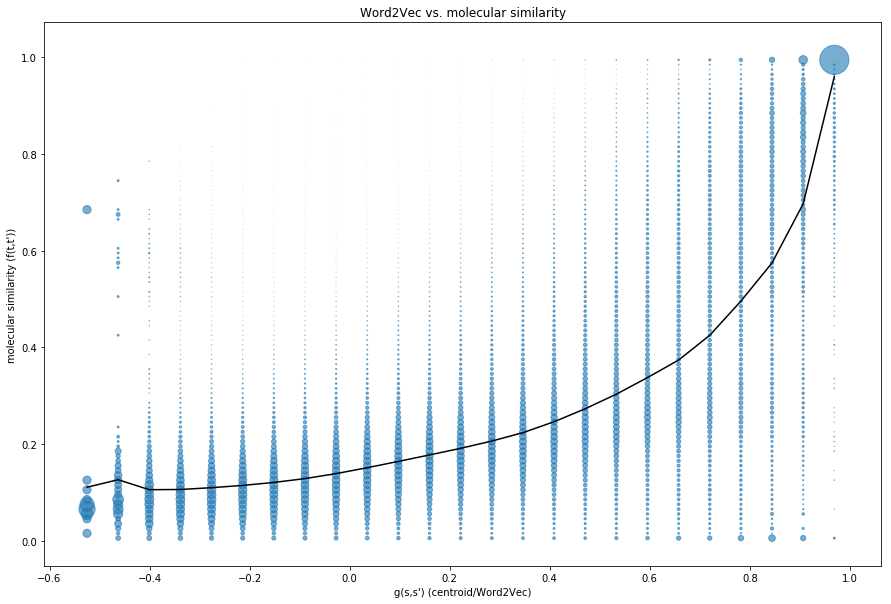

In [32]:
fig, ax = plt.subplots(figsize=(15,10))
cm = plt.cm.get_cmap('copper_r')  #plt.cm.get_cmap('RdYlBu')

ax.scatter(data_x, data_y, s=1000*np.array(data_z_norm), cmap=cm, alpha=0.6)
plt.plot(data_x, data_y_mean, color='black')
plt.xlabel("g(s,s') (centroid/Word2Vec)")
plt.ylabel("molecular similarity (f(t,t'))")
plt.title("Word2Vec vs. molecular similarity")

Set similarity threshold to:  0.8505918971390208


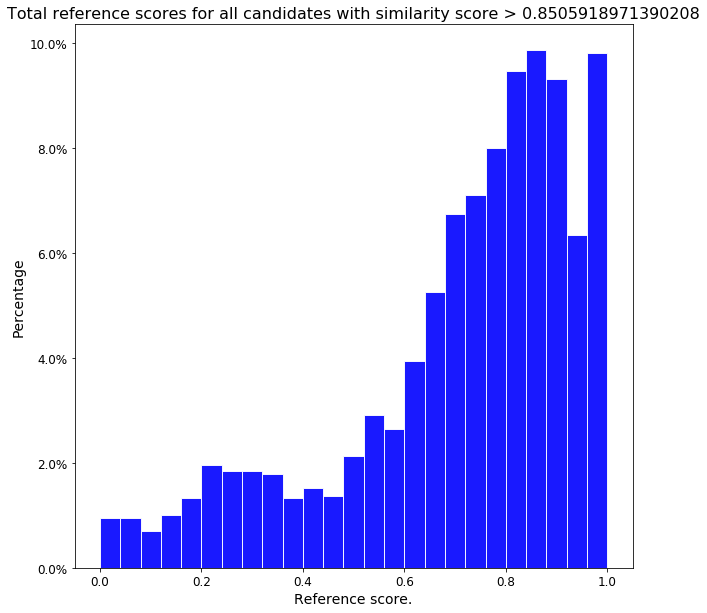

Percentage of highly similar molecules within selection:  83.4 %


In [33]:
num_best = 10000
threshold = np.sort(M_sim_ctr.reshape(M_sim_ctr.shape[0]**2))[-(num_best + M_sim_ctr.shape[0])]  
print("Set similarity threshold to: ", threshold)
n, bins = MS_functions.similarity_histogram(M_sim_ctr, tanimoto_similarities, threshold, 
                                            num_bins=25, exclude_IDs = exclude, filename = "Hist_w2v_centroid.png")

# Arbitrary threshold: call everything above a score of 0.48 "highly similar". 
print("Percentage of highly similar molecules within selection: ", np.round(100*np.sum(n[12:]), 2), "%")

In [34]:
data_x = []
data_y = []
data_z = []
for i in range(bins_x):
    data_x.append(edges[0][i] + 0.5*np.diff(edges[0][:2])[0])
#        data_y.append(edges[1][j] + 0.5*np.diff(edges[1][:2])[0])
    mean_mol_score = np.sum(H[i,:]*(edges[1][:bins_y] + edges[1][1]/2))/(np.sum(H[i,:]))
    data_y.append(mean_mol_score)
    data_z.append(np.sum(H[i,:]))

Text(0, 0.5, "molecular similarity (f(t,t'))")

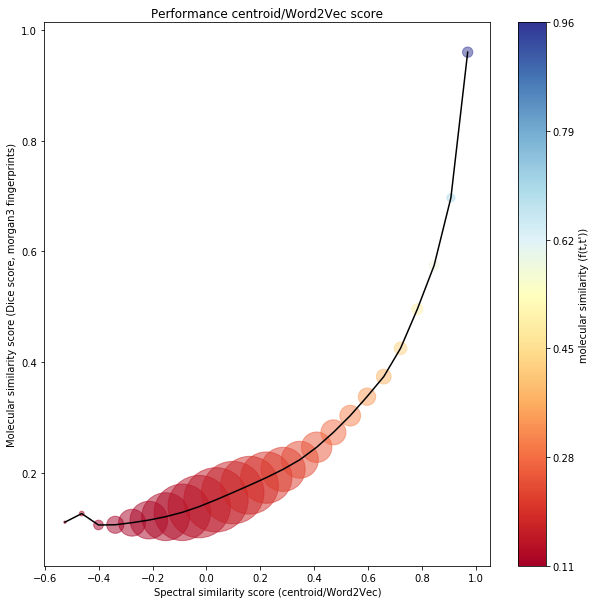

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
cm = plt.cm.get_cmap('RdYlBu')

plt.scatter(data_x, data_y, s = np.array(data_z)**0.5, c = data_y, cmap=cm, alpha = 0.5)
plt.plot(data_x, data_y, color='black')
plt.xlabel("Spectral similarity score (centroid/Word2Vec)")
plt.ylabel("Molecular similarity score (Dice score, morgan3 fingerprints)")
plt.title("Performance centroid/Word2Vec score" )

# Optionally add a colorbar
max_color = np.max(data_y)
min_color = np.min(data_y)
color_ticks = np.round(np.linspace(min_color, max_color, 6),2)
cax, _ = matplotlib.colorbar.make_axes(ax)
cbar = matplotlib.colorbar.ColorbarBase(cax, cmap=cm, ticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
cbar.ax.set_yticklabels([x for x in list(color_ticks)])
plt.ylabel("molecular similarity (f(t,t'))")